# README

This takes the data generated from gen_alphaData.py and converts it into graphs. This experiment is focusing on three curves. One of the curves is fixated at TI = 0 and the other two are variable around the null points. We are only looking at a small subset of TI combinations. We are interested to know how the changing the alpha value of AIC influences the MSE of parameters.

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator
from tslearn.clustering import KernelKMeans
from matplotlib import colors

c:\co\NIA\Stabilization\.venv\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Initialization

In [2]:
cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'alphaData'
exp_date = '03Oct23'

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

c:\co\NIA\


In [3]:
with open(f'{cwd_full}\{base_file}\CustomObjFunc_AIC\{exp_file}\hprParameter_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SNR_value = dict["SNR_value"]
    TI1_array = dict['TI1_region']
    TI2_array = dict['TI2_region']
    alpha_array = dict['alpha_region']
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    AIC_eval_iter = dict['AIC_eval_iter']
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

In [4]:
def to_readable(file):
    df = pd.read_pickle(file)
    ALL_TI = np.stack(df["TI_combo"].values) #shape: (voxel)
    ALL_AL = np.stack(df["alpha"].values) #shape: (voxel)
    ALL_MSE = np.stack(df["MSE"].values) #shape: (voxel)
    ALL_VAR = np.stack(df["var"].values) #shape: (voxel)

    ALL_BIAS = df["bias"].values #shape: (voxel, lambda, popt)
    ALL_AIC = df["AIC"].values #shape: (voxel, lambda)
    
    return ALL_TI, ALL_AL, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

In [5]:
def prepare_data(p_oi):

    MSE_ordered = np.zeros((len(TI2_array), len(TI1_array), len(alpha_array), 3))
    var_ordered = np.zeros((len(TI2_array), len(TI1_array), len(alpha_array), 3))
    bias_ordered = np.zeros((len(TI2_array), len(TI1_array), len(alpha_array), 3))
    AIC_ordered = np.zeros((len(TI2_array), len(TI1_array), len(alpha_array), 3))

    data_name = f"{cwd_full}\{base_file}\CustomObjFunc_AIC\{exp_file}\{'a'}lphaData_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    TI_combo, ALPHA, MSE, VAR, BIAS, AIC = to_readable(data_name)

    for index in range(TI_combo.shape[0]):

        TI1_part = TI_combo[index][0]
        TI2_part = TI_combo[index][1]
        alpha_part = ALPHA[index]

        TI1_index = np.where(TI1_array==TI1_part)[0][0]
        TI2_index = np.where(TI2_array==TI2_part)[0][0]
        alpha_index = np.where(alpha_array == alpha_part)[0][0]

        AIC_ordered[TI2_index, TI1_index, alpha_index, :] = AIC[index]/var_reps
        MSE_ordered[TI2_index, TI1_index, alpha_index, :] = MSE[index][:,p_oi]
        var_ordered[TI2_index, TI1_index, alpha_index, :] = VAR[index][:,p_oi]
        bias_ordered[TI2_index, TI1_index, alpha_index, :] = BIAS[index][:,p_oi]

    return MSE_ordered, var_ordered, bias_ordered, AIC_ordered

In [6]:
MSE, var, bias, AIC = prepare_data(param_oi)

Retrieving data for c:\co\NIA\\Stabilization\CustomObjFunc_AIC\alphaData\alphaData_03Oct23.pkl


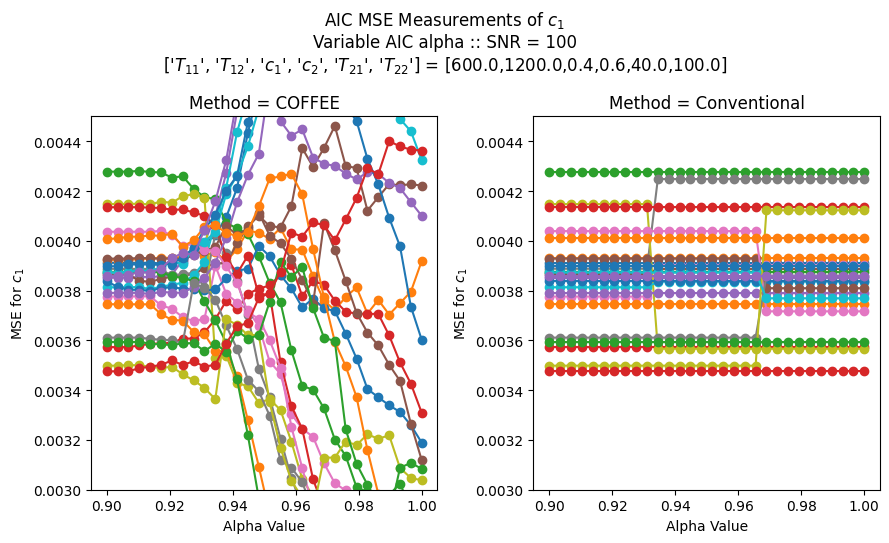

In [12]:
ordering = ["COFFEE", "Conventional", "Curve Fit"]

fig, ax = plt.subplots(1, 2, figsize=(9,5.5), tight_layout=True)
fig.suptitle(f"AIC MSE Measurements of {ParamTitle_6p[param_oi]}\nVariable AIC alpha :: SNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

for iter in range(2):

    for iTI1 in range(len(TI1_array)):
        for iTI2 in range(len(TI2_array)):
            ax[iter].plot(alpha_array, MSE[iTI1, iTI2, :, iter], label = f'TI1 = {TI1_array[iTI1]} :: TI1 = {TI2_array[iTI2]}', ls = '-', marker = 'o')

    ax[iter].set_xlabel('Alpha Value')
    ax[iter].set_ylabel(f'MSE for {ParamTitle_6p[param_oi]}')
    ax[iter].set_title(f'Method = {ordering[iter]}')

    # ax[iter].set_xlim([0,1])
    ax[iter].set_ylim([0.003,0.0045])


In [8]:
COFFEE_data = MSE[:, :, :, 0]
rs_COFFEE_data = np.reshape(COFFEE_data, (-1,len(alpha_array)))

gak_km = KernelKMeans(n_clusters=3,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=False,
                      random_state=0)
y_pred = gak_km.fit_predict(rs_COFFEE_data)

print(y_pred.shape)

c:\co\NIA\Stabilization\.venv\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 25 1-dimensional timeseries
  warnings.warn(


(25,)


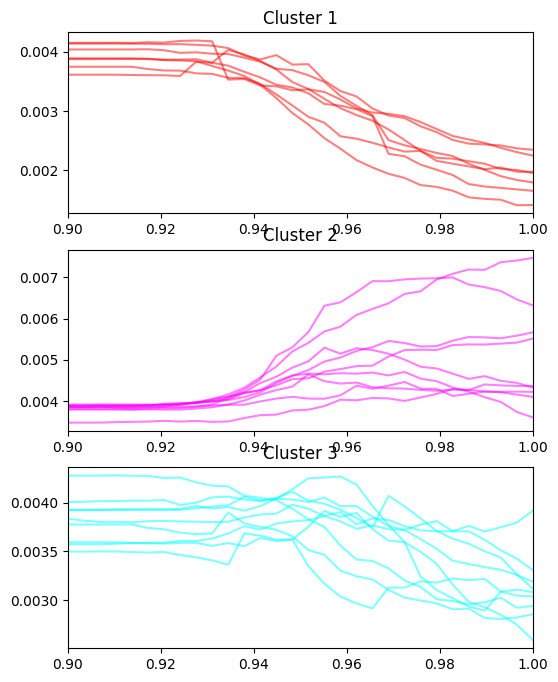

In [9]:
plt.figure(figsize=(6,8))
gen_colors = [(1,0,0), (1,0,1), (0,1,1)]
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in rs_COFFEE_data[y_pred == yi]:
        plt.plot(alpha_array, xx.ravel(), "-", color = gen_colors[yi], alpha=.5)
    plt.xlim(0.9, 1)
    plt.title("Cluster %d" % (yi + 1))

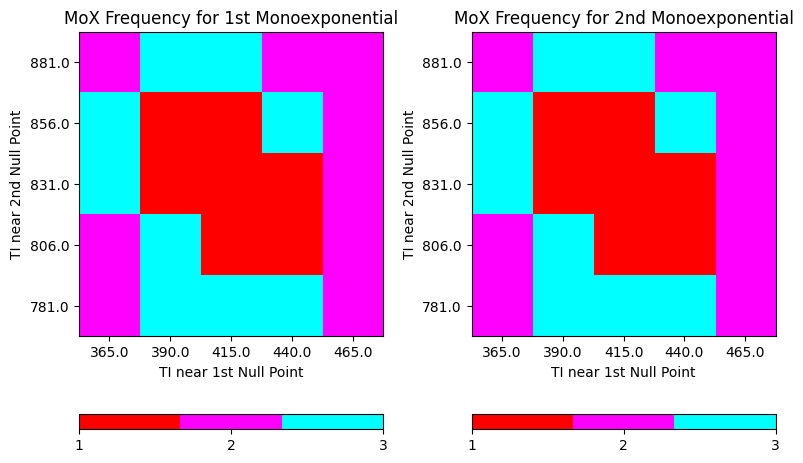

In [13]:
rs_y_pred = np.reshape(y_pred,(len(TI1_array),len(TI2_array)))


mTI_np1, mTI_np2 = np.meshgrid(TI1_array, TI2_array)
ordering = ["Biexponential Curve", "1st Monoexponential", "2nd Monoexponential"]

fig, ax = plt.subplots(1, 2, figsize=(8,5.5), tight_layout=True)
# fig.suptitle(f"AIC Monoexponential Frequency with MSE diff > {threshold}\nSNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

cmap = colors.ListedColormap(gen_colors)

for iter in range(2):
    
    cp = ax[iter].imshow(rs_y_pred+1, cmap = cmap, origin = 'lower')
    ax[iter].set(xticks=np.arange(0,len(TI1_array),1), xticklabels = TI1_array)
    ax[iter].set(yticks=np.arange(0,len(TI2_array),1), yticklabels = TI2_array)
    cb = fig.colorbar(cp, ax = ax[iter], location = 'bottom')
    cb.locator = MultipleLocator(1)
    cb.update_ticks()

    # ax[iter].axhline(y = TI2star, color = 'k', ls = '-.', label = 'Null Point 2')
    # ax[iter].axvline(x = TI1star, color = 'k', ls = '--', label = 'Null Point 1')

    # ax[iter].axhline(y = low_AIC_TI2, color = 'm')
    # ax[iter].axhline(y = high_AIC_TI2, color = 'm')
    # ax[iter].axvline(x = low_AIC_TI1, color = 'm')
    # ax[iter].axvline(x = high_AIC_TI1, color = 'm')
    # ax[iter].plot(mTI_np1, mTI_np2, ls = '', marker = 'o', color = 'g')

    ax[iter].set_xlabel('TI near 1st Null Point')
    ax[iter].set_ylabel('TI near 2nd Null Point')
    ax[iter].set_title(f'MoX Frequency for {ordering[iter+1]}')